# **IMPORTS**

In [3]:
import numpy as np
import pandas as pd
import random
import os
import itertools

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()  # sets the matplotlib style to seaborn style

# Scipy
from scipy.io import loadmat
from scipy.ndimage import convolve1d
from scipy.signal import butter, sosfiltfilt, welch

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.decomposition import PCA

In [4]:
base_path = './Dataset1_DB1/'
# Initialize a dictionary to store data for all subjects
subjects_data = {}
# Loop through all 27 subjects and load data
for subject_id in range(1, 28):
    subject_folder = f's{subject_id}'  # Subject folder name (e.g., 's1', 's2', ..., 's27')
    EMG_file_name = os.path.join(base_path, subject_folder, f'S{subject_id}_A1_E1.mat')
    # Load EMG data for the subject
    emg_data = loadmat(EMG_file_name)
    # Store the loaded data in the dictionary
    subjects_data[subject_id] = emg_data
    



In [5]:

def check_channel(stimulus, repetition, emg):
    # -1 because 0 is the resting condition
    n_stimuli = len(np.unique(stimulus)) - 1 
    # -1 because 0 is not a repetition
    n_repetitions = len(np.unique(repetition)) - 1 
    n_channels = emg.shape[1]

    #defining the length of the moving average window
    mov_mean_length = 25
    mov_mean_weights = np.ones(mov_mean_length) / mov_mean_length

    #initializing the data structure
    emg_windows = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]
    emg_envelopes = [[None for repetition_idx in range(n_repetitions)] for stimuli_idx in range(n_stimuli)]

    for stimuli_idx in range(n_stimuli):
        for repetition_idx in range(n_repetitions):
            idx = np.logical_and(stimulus == stimuli_idx + 1, repetition == repetition_idx + 1).flatten()
            emg_windows[stimuli_idx][repetition_idx] = emg[idx, :]
            emg_envelopes[stimuli_idx][repetition_idx] = convolve1d(emg_windows[stimuli_idx][repetition_idx], mov_mean_weights, axis=0)
    # Now we plot all the channels on the same y-scale
    fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
    ax = ax.ravel()

    number_of_emg_channels = emg.shape[-1]
    # plot Rectified EMG signal
    for channel_idx in range(number_of_emg_channels): 
        ax[channel_idx].plot(emg_windows[0][0][:, channel_idx])
        ax[channel_idx].set_title(f"Channel {channel_idx+1}")
    plt.suptitle("Rectified EMG signal")

    # plot Envelopes of the EMG signal
    fig, ax = plt.subplots(2, 5, figsize=(12, 6), constrained_layout=True, sharex=True, sharey=True)
    ax = ax.ravel()
    for channel_idx in range(number_of_emg_channels): 
        ax[channel_idx].plot(emg_envelopes[0][0][:, channel_idx])
        ax[channel_idx].set_title(f"Channel {channel_idx+1}")
    plt.suptitle("Envelopes of the EMG signal")
    plt.show()



## **Check for Corupted signal**

In [6]:
# for subject_id, emg_data in subjects_data.items():
#     stimulus = emg_data['stimulus']
#     repetition = emg_data['repetition']
#     emg = emg_data['emg']
#     n_situmil = len(np.unique(stimulus)) - 1
#     n_repetitions = len(np.unique(repetition)) - 1
#     check_channel(stimulus, repetition, emg)
    

## **EXTRACT FEATURES**

In [7]:
def build_dataset_from_ninapro(emg, stimulus, repetition, features=None):
    # Calculate the number of unique stimuli and repetitions, subtracting 1 to exclude the resting condition
    n_stimuli = np.unique(stimulus).size - 1
    n_repetitions = np.unique(repetition).size - 1
    # Total number of samples is the product of stimuli and repetitions
    n_samples = n_stimuli * n_repetitions
    
    # Number of channels in the EMG data
    n_channels = emg.shape[1]
    # Calculate the total number of features by summing the number of channels for each feature
    n_features = sum(n_channels for feature in features)
    
    # Initialize the dataset and labels arrays with zeros
    dataset = np.zeros((n_samples, n_features))
    labels = np.zeros(n_samples)
    current_sample_index = 0
    
    # Loop over each stimulus and repetition to extract features
    for i in range(n_stimuli):
        for j in range(n_repetitions):
            # Assign the label for the current sample
            labels[current_sample_index] = i + 1
            # Calculate the current sample index based on stimulus and repetition
            current_sample_index = i * n_repetitions + j
            current_feature_index = 0
            # Select the time steps corresponding to the current stimulus and repetition
            selected_tsteps = np.logical_and(stimulus == i + 1, repetition == j + 1).squeeze()
            
            # Loop over each feature function provided
            for feature in features:
                # Determine the indices in the dataset where the current feature will be stored
                selected_features = np.arange(current_feature_index, current_feature_index + n_channels)
                # Apply the feature function to the selected EMG data and store the result
                dataset[current_sample_index, selected_features] = feature(emg[selected_tsteps, :])
                # Update the feature index for the next feature
                current_feature_index += n_channels

            # Move to the next sample
            current_sample_index += 1
            
    # Return the constructed dataset and corresponding labels
    return dataset, labels


# Mean absolute value (MAV)
mav = lambda x: np.mean(np.abs(x), axis=0)
# Standard Deviation (STD)
std = lambda x: np.std(x, axis=0)
# Maximum absolute Value (MaxAV)
maxav = lambda x: np.max(np.abs(x), axis=0)
# Root mean square (RMS)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))
# Waveform length (WL)
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)
# Slope sign changes (SSC)
ssc = lambda x: np.sum((np.diff(x, axis=0)[:-1, :] * np.diff(x, axis=0)[1:, :]) < 0, axis=0)

## **CREATE DATASET**

In [8]:
dic_of_data = {}
for subject_id, emg_data in subjects_data.items():
    stimulus = emg_data['restimulus']
    repetition = emg_data['rerepetition']
    emg = emg_data['emg']
    n_stimuli = len(np.unique(stimulus)) - 1 # -1 because 0 is the resting condition
    n_repetitions = len(np.unique(repetition)) - 1 # -1 because 0 is not a repetition
    dataset, labels = build_dataset_from_ninapro(emg, 
                                                 stimulus, 
                                                 repetition, 
                                                 features=[mav, std, maxav, rms, wl, ssc])

    n_channels = emg.shape[1] 
    feature_names = ["MAV", "STD", "MAXAV", "RMS", "WL", "SSC"] 
    row_indices = [f"Movement {i+1} - Repetition {j+1}" 
                for i in range(n_stimuli) for j in range(n_repetitions)]
    column_indices = [f"Channel {ch+1} - {feat}" 
                    for feat in feature_names for ch in range(n_channels)]

    df = pd.DataFrame(dataset, index=row_indices, columns=column_indices)
    df["Label"] = labels
    dic_of_data[subject_id] = df

In [9]:
dic_of_data[1].head(10)

,Channel 1 - MAV,Channel 2 - MAV,Channel 3 - MAV,Channel 4 - MAV,Channel 5 - MAV,Channel 6 - MAV,Channel 7 - MAV,Channel 8 - MAV,Channel 9 - MAV,Channel 10 - MAV,...,Channel 2 - SSC,Channel 3 - SSC,Channel 4 - SSC,Channel 5 - SSC,Channel 6 - SSC,Channel 7 - SSC,Channel 8 - SSC,Channel 9 - SSC,Channel 10 - SSC,Label
Movement 1 - Repetition 1,0.032035,0.026077,0.038698,0.006725,0.002973,0.002546,0.122308,0.052028,0.028823,0.017328,...,23.0,44.0,16.0,10.0,2.0,51.0,46.0,22.0,27.0,1.0
Movement 1 - Repetition 2,0.061945,0.108569,0.017273,0.005140,0.003027,0.002456,0.084392,0.052752,0.095440,0.030413,...,62.0,42.0,13.0,22.0,0.0,76.0,48.0,62.0,35.0,1.0
Movement 1 - Repetition 3,0.021332,0.201103,0.069829,0.016184,0.005503,0.002707,0.176177,0.050905,0.189563,0.076639,...,79.0,51.0,27.0,24.0,4.0,89.0,45.0,74.0,55.0,1.0
Movement 1 - Repetition 4,0.049548,0.369639,0.233292,0.053191,0.021031,0.007250,0.300051,0.094615,0.398607,0.176764,...,91.0,77.0,39.0,44.0,16.0,102.0,73.0,84.0,84.0,1.0
Movement 1 - Repetition 5,0.010922,0.097785,0.009997,0.005106,0.002974,0.002479,0.111033,0.049916,0.059035,0.028439,...,65.0,45.0,18.0,18.0,3.0,103.0,62.0,53.0,66.0,1.0
Movement 1 - Repetition 6,0.022233,0.259228,0.124427,0.021193,0.006101,0.002626,0.162890,0.061045,0.297452,0.125404,...,99.0,80.0,32.0,25.0,5.0,92.0,62.0,93.0,77.0,1.0
Movement 1 - Repetition 7,0.029638,0.248389,0.232615,0.025298,0.008730,0.002938,0.141827,0.075628,0.398138,0.115132,...,93.0,111.0,32.0,35.0,12.0,104.0,76.0,114.0,82.0,1.0
Movement 1 - Repetition 8,0.012352,0.084492,0.044576,0.005473,0.003154,0.002436,0.144689,0.058769,0.134262,0.047309,...,54.0,55.0,21.0,28.0,4.0,115.0,58.0,85.0,55.0,1.0
Movement 1 - Repetition 9,0.011704,0.120620,0.070755,0.005481,0.002792,0.002417,0.080718,0.056663,0.169144,0.056833,...,74.0,74.0,16.0,25.0,2.0,80.0,54.0,99.0,68.0,1.0
Movement 1 - Repetition 10,0.016862,0.165763,0.131348,0.006439,0.002827,0.002582,0.131971,0.062391,0.254436,0.145750,...,69.0,85.0,16.0,17.0,1.0,81.0,42.0,88.0,64.0,1.0


# **STD HEAT MAPS**

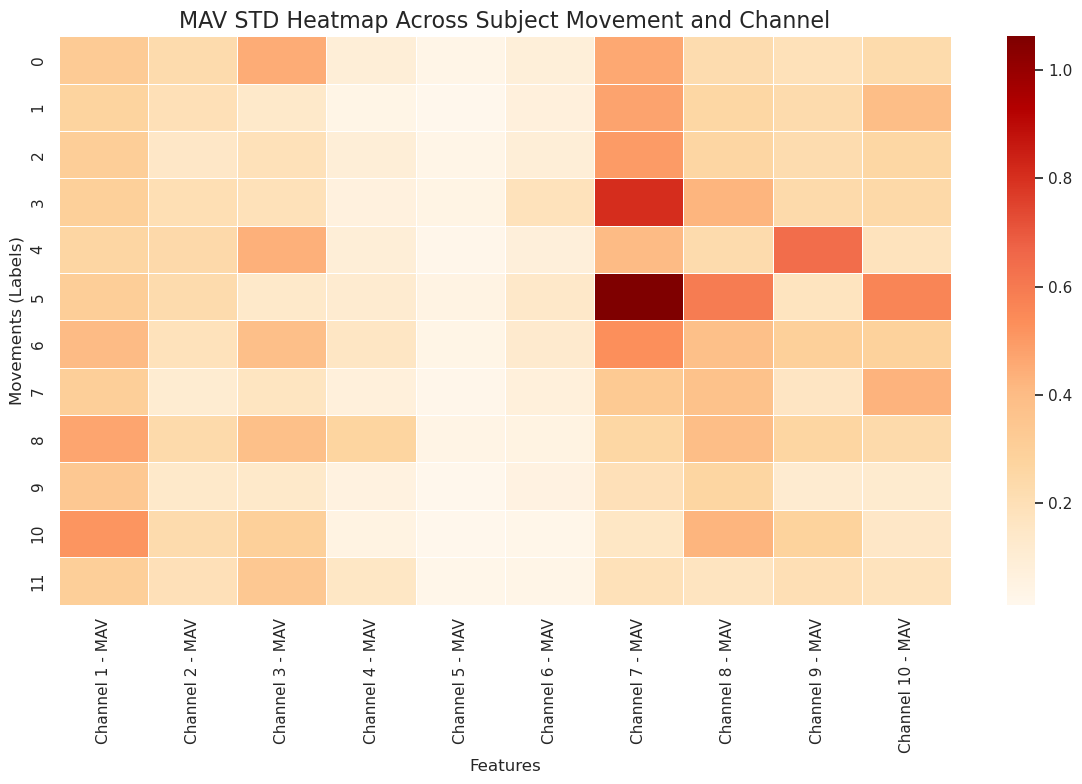

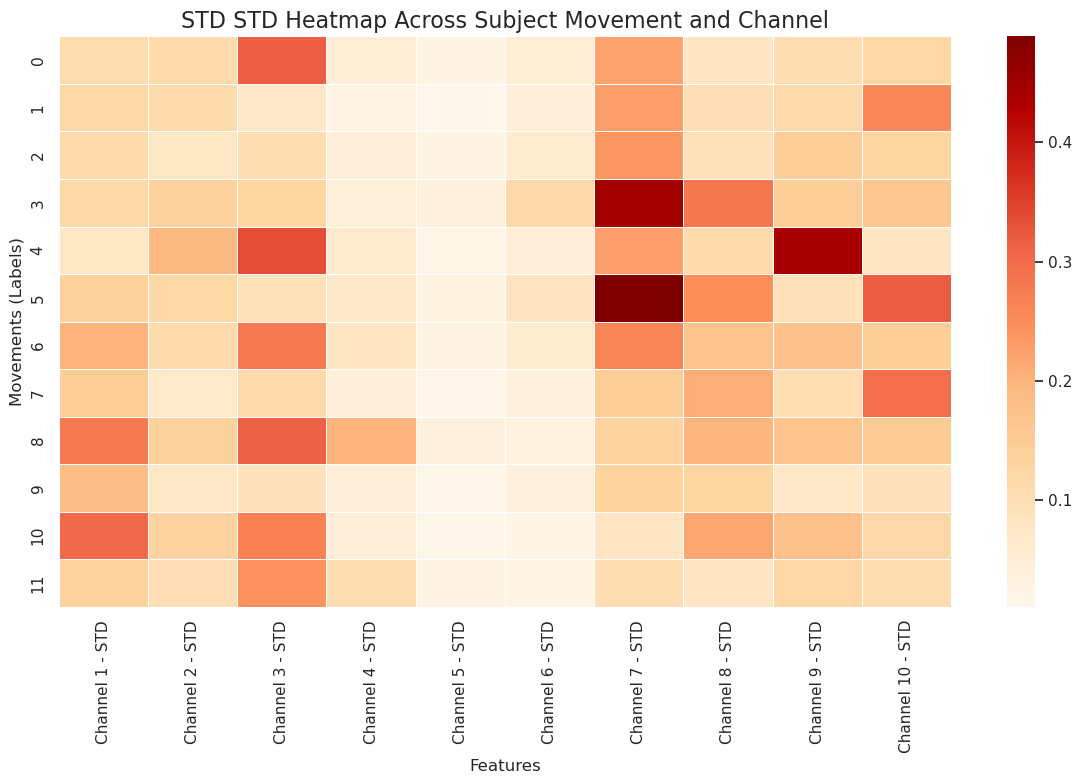

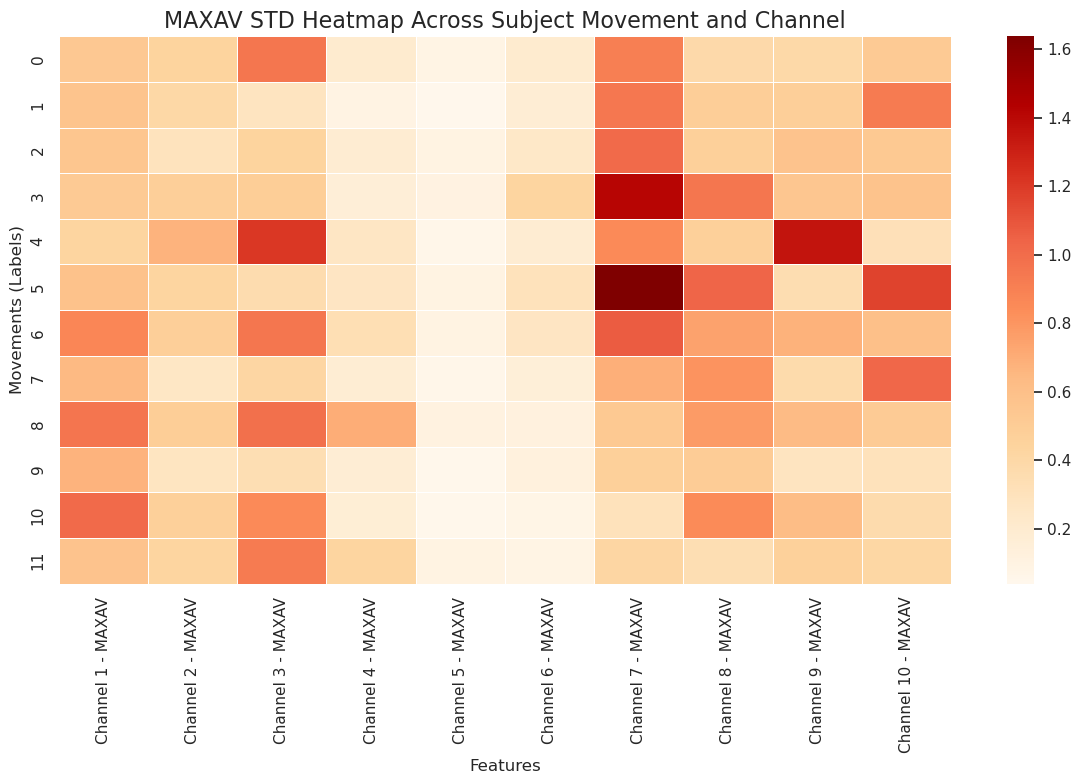

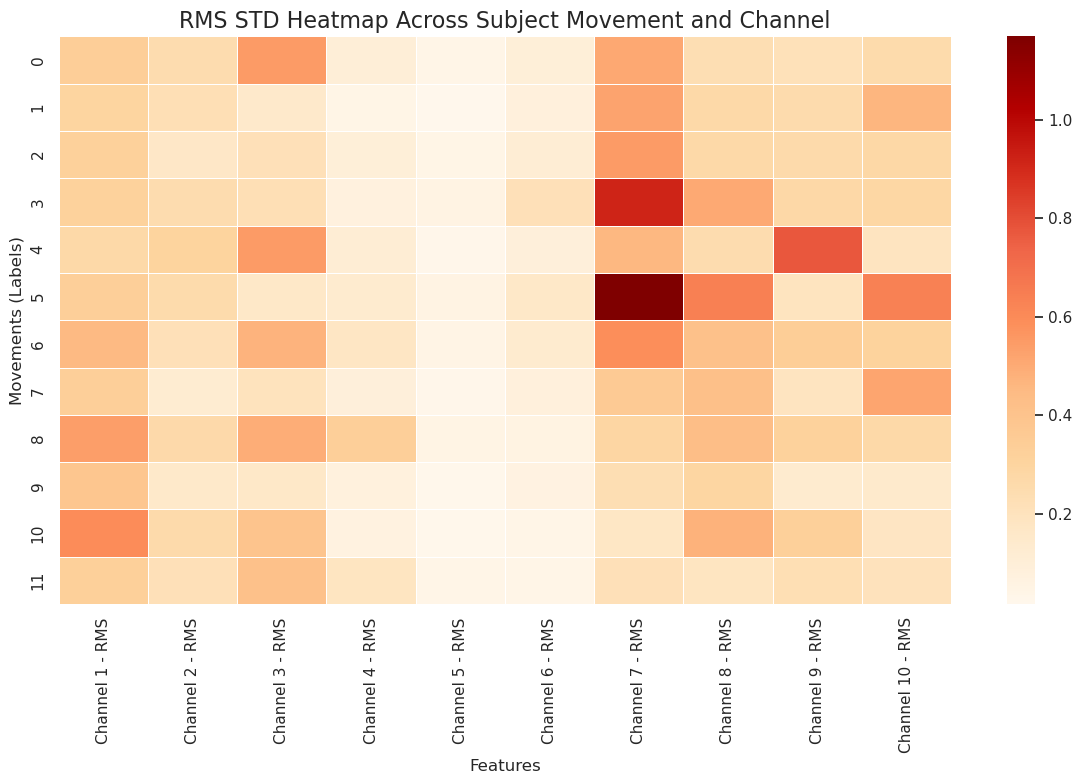

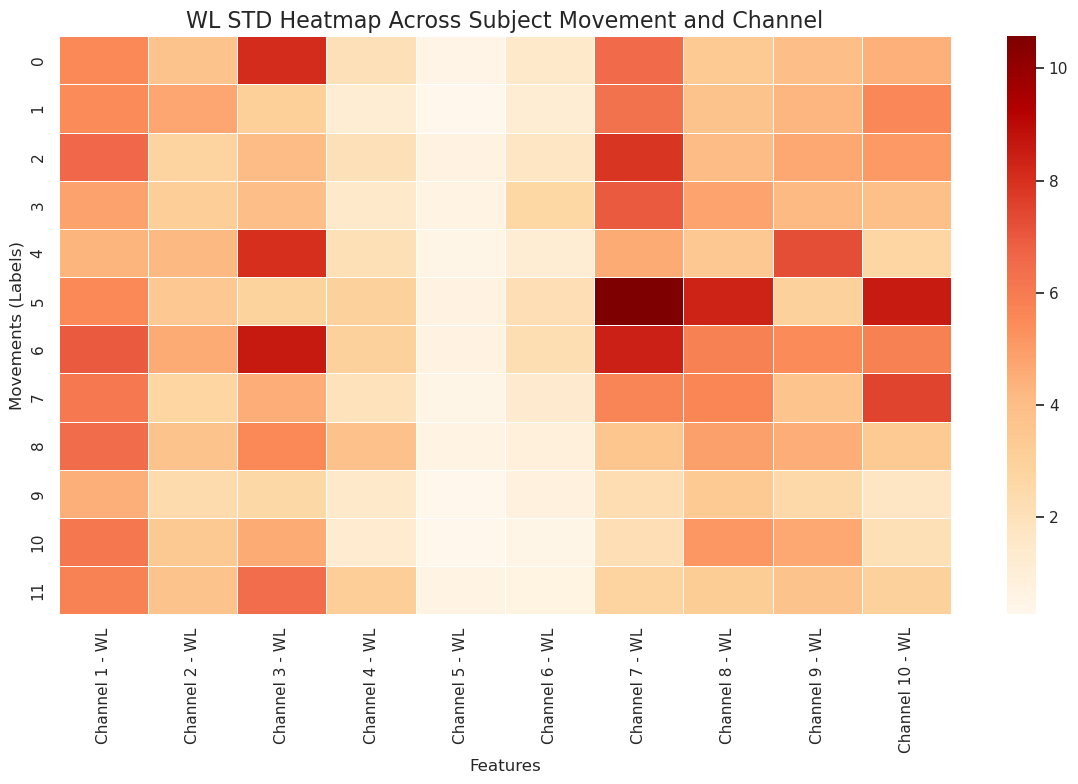

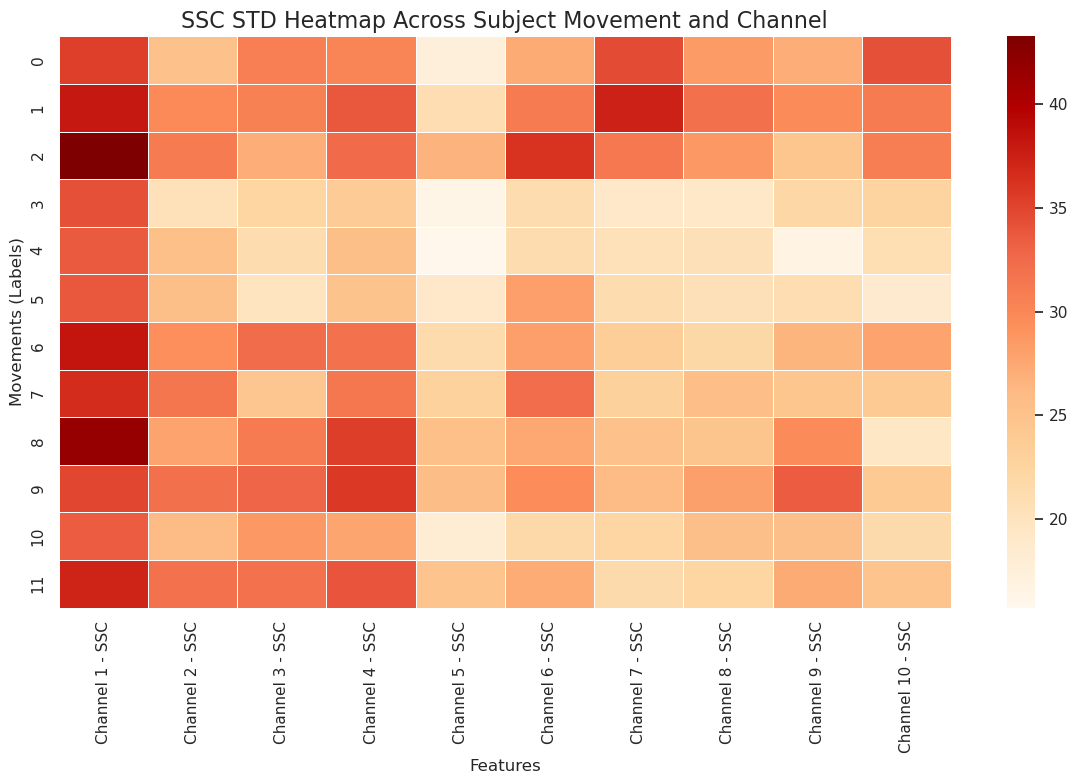

In [10]:
import pandas as pd

combined_data = []
for df in dic_of_data.values():
    combined_data.append(df.groupby("Label").mean())

combined_data = pd.concat([i for i in combined_data], keys=[f"Subject_{i}" for i in range(1,28)], names=['Subject', 'Index'])
combined_data.reset_index(inplace=True)
combined_data.drop(columns="Subject", inplace=True)
combined_data =combined_data.groupby("Index").std()
combined_data.reset_index(inplace=True)
combined_data.head(10)

df = combined_data.copy()
df.drop(columns="Index", inplace=True)
df_f = []
for i in range(6):
    df_f.append(df.iloc[:, 10*i :10*i + 10])


feature_names = ["MAV", "STD", "MAXAV", "RMS", "WL", "SSC"] 
for n,data in enumerate(df_f):
    plt.figure(figsize=(12, 8))  # Adjust figure size as needed
    sns.heatmap(data, annot=False, cmap="OrRd", cbar=True, linewidths=0.5)

    # Step 2: Add titles and labels
    plt.title(f"{feature_names[n]} STD Heatmap Across Subject Movement and Channel", fontsize=16)
    plt.xlabel("Features", fontsize=12)
    plt.ylabel("Movements (Labels)", fontsize=12)

    # Step 3: Show the plot
    plt.tight_layout()
    plt.show()



In [11]:
features = ["MAV", "STD", "MAXAV", "RMS", "WL", "SSC"]
data_df = dic_of_data[1]
movements = sorted(set(idx.split(" - ")[0] for idx in data_df.index))  # Unique movements
repetitions = sorted(set(idx.split(" - ")[1] for idx in data_df.index))  # Unique repetitions


# **USEFULL TRAINING FUNCTIONS**

In [12]:
def create_data_set(idx_concat, idx_free, dic_data):
    concatenated_df = pd.concat([dic_data[idx] for idx in idx_concat], axis=0, ignore_index=True)
    free_idx_df = dic_data[idx_free]
    return concatenated_df, free_idx_df


def train_and_evaluate(X_train, y_train, X_test, y_test):

    # Step 1: Normalize the data
    scaler = StandardScaler()
    X_train_z = scaler.fit_transform(X_train)
    X_test_z = scaler.transform(X_test)

    # Step 2: Define and train the SVM model with fixed parameters
    clf = SVC(C=0.05, kernel='linear', gamma='scale')  # Predefined hyperparameters
    clf.fit(X_train_z, y_train)

    # Step 3: Predict on the test set
    y_pred = clf.predict(X_test_z)

    # Step 4: Calculate accuracy and F1 score
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    return acc, f1


## **USING 1 RANDOM SUBJECT AS TEST AND THE REST FOR TRAINING**

In [13]:
# choose randomly
all_sub = list(range(1, 28))
test_idx = 18 #np.random.choice(all_sub)
all_sub.pop(test_idx-1)

train, test = create_data_set(all_sub,test_idx,dic_of_data)
x_train = train.drop(columns=["Label"]).reset_index(drop=True)
y_train = train["Label"].reset_index(drop=True)
x_test = test.drop(columns=["Label"]).reset_index(drop=True)
y_test = test["Label"].reset_index(drop=True)

acc, f1 = train_and_evaluate(x_train, y_train, x_test, y_test)
print(F"======================= RANDOM TEST : {test_idx} =======================")
print(f"Accuracy = {acc:.4f}, F1-Score = {f1:.4f}\n")



======================= RANDOM TEST : 18 =======================
Accuracy = 0.3583, F1-Score = 0.3206



## **CROSS-VALIDATION ROTATING THE SUBJECT USED FOR TESTING**

In [14]:
dic_all_comb = {}
all_sub = list(range(1, 28))
for i in all_sub : 
    subject_list = all_sub.copy()
    test_idx = i
    subject_list.pop(test_idx-1)
    dic_all_comb[i] = subject_list

performances_metric = {}
for test_idx, train_idx in dic_all_comb.items():
    print(F"======================= Test: {test_idx} =======================")
    train, test = create_data_set(train_idx,test_idx,dic_of_data)
    x_train = train.drop(columns=["Label"]).reset_index(drop=True)
    y_train = train["Label"].reset_index(drop=True)
    x_test = test.drop(columns=["Label"]).reset_index(drop=True)
    y_test = test["Label"].reset_index(drop=True)
    acc, f1 = train_and_evaluate(x_train, y_train, x_test, y_test)
    performances_metric[test_idx] = {"Accuracy": acc, "F1-Score": f1}
    print(f"Accuracy = {acc:.4f}, F1-Score = {f1:.4f}\n")


======================= Test: 1 =======================
Accuracy = 0.4500, F1-Score = 0.3698

======================= Test: 2 =======================
Accuracy = 0.0750, F1-Score = 0.0600

======================= Test: 3 =======================
Accuracy = 0.3583, F1-Score = 0.3218

======================= Test: 4 =======================
Accuracy = 0.2500, F1-Score = 0.2167

======================= Test: 5 =======================
Accuracy = 0.5250, F1-Score = 0.4602

======================= Test: 6 =======================
Accuracy = 0.2500, F1-Score = 0.2020

======================= Test: 7 =======================
Accuracy = 0.1917, F1-Score = 0.1233

======================= Test: 8 =======================
Accuracy = 0.5583, F1-Score = 0.5035

======================= Test: 9 =======================
Accuracy = 0.2500, F1-Score = 0.1967

======================= Test: 10 =======================
Accuracy = 0.4167, F1-Score = 0.3637

======================= Test: 11 =======================
Ac

# **PLOT K-FOLD**

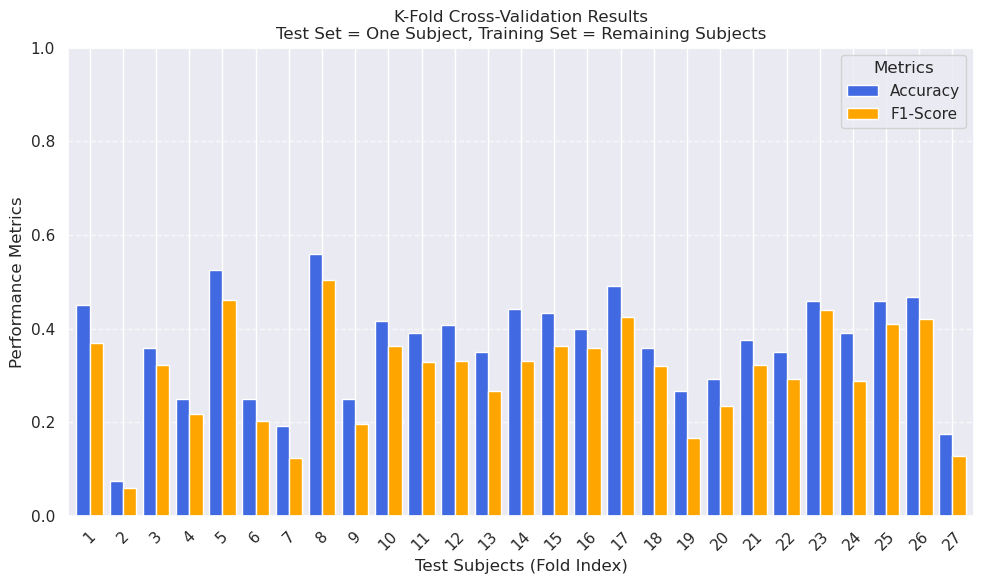

,Mean ± Std,Min,Max
Accuracy,0.36 ± 0.11,0.075000,0.558333
F1-Score,0.31 ± 0.11,0.059969,0.503471


In [15]:
import matplotlib.pyplot as plt
import pandas as pd

performance_df = pd.DataFrame(performances_metric).T  # Transpose to get subjects as rows
fig, ax = plt.subplots(figsize=(10, 6))

performance_df.plot(kind="bar", ax=ax, width=0.8, color=["royalblue", "orange"])

plt.title("K-Fold Cross-Validation Results\nTest Set = One Subject, Training Set = Remaining Subjects")
plt.xlabel("Test Subjects (Fold Index)")
plt.ylabel("Performance Metrics")
plt.xticks(rotation=45)  # Rotate x-axis labels for clarity
plt.ylim(0, 1)  # Assuming metrics are between 0 and 1
plt.legend(title="Metrics", loc="upper right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


summary_df = pd.DataFrame({
    "Mean ± Std": [f"{performance_df['Accuracy'].mean():.2f} ± {performance_df['Accuracy'].std():.2f}",
                   f"{performance_df['F1-Score'].mean():.2f} ± {performance_df['F1-Score'].std():.2f}"],
    "Min": [performance_df['Accuracy'].min(), performance_df['F1-Score'].min()],
    "Max": [performance_df['Accuracy'].max(), performance_df['F1-Score'].max()]
}, index=["Accuracy", "F1-Score"])


summary_df



## **EFFECT OF TRAINING SIZE**

Repeat task 3 by varying the number of subjects in the training set (without performing 
cross-validation). For example, use subject 27 for testing, and train with subject 1, then 
train with subjects 1 and 2, then 1, 2, and 3, and continue to increase number of 
subjects used for training. Analyze how the size of the training set impacts the 
classification performance on the test subject. Discuss the potential effects of including 
more or fewer subjects in the training data, focusing on trends in generalization and 
accuracy.

**progressive incrementation**

=============== RANDOM TEST SUBJECT :  8  ===================
Accuracy = 0.2000, F1-Score = 0.1489
Accuracy = 0.1500, F1-Score = 0.1231
Accuracy = 0.1167, F1-Score = 0.0829
Accuracy = 0.1833, F1-Score = 0.1539
Accuracy = 0.3000, F1-Score = 0.2200
Accuracy = 0.3500, F1-Score = 0.2768
Accuracy = 0.3667, F1-Score = 0.3452
Accuracy = 0.3750, F1-Score = 0.3207
Accuracy = 0.4000, F1-Score = 0.3793
Accuracy = 0.4500, F1-Score = 0.4263
Accuracy = 0.4417, F1-Score = 0.4061
Accuracy = 0.4250, F1-Score = 0.3961
Accuracy = 0.4333, F1-Score = 0.3964
Accuracy = 0.4167, F1-Score = 0.3690
Accuracy = 0.4750, F1-Score = 0.4313
Accuracy = 0.5000, F1-Score = 0.4474
Accuracy = 0.5000, F1-Score = 0.4565
Accuracy = 0.5250, F1-Score = 0.4567
Accuracy = 0.5333, F1-Score = 0.4670
Accuracy = 0.5417, F1-Score = 0.4737
Accuracy = 0.5083, F1-Score = 0.4450
Accuracy = 0.5417, F1-Score = 0.4802
Accuracy = 0.5417, F1-Score = 0.5026
Accuracy = 0.5083, F1-Score = 0.4603
Accuracy = 0.5417, F1-Score = 0.5004
Accuracy = 0.

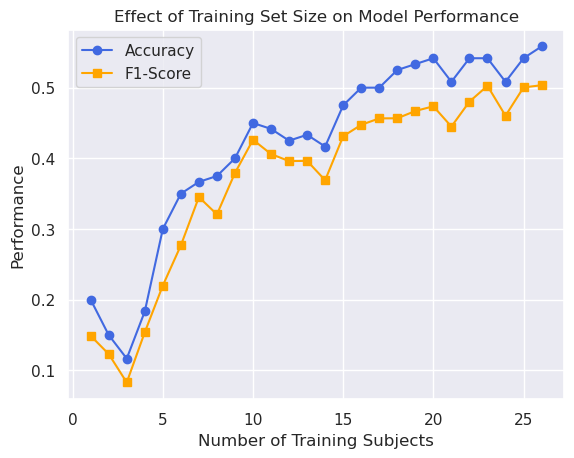

In [16]:
import numpy as np
all_subj = list(range(1, 28))
pro_incre = []
test_idx = 8 #np.random.choice(all_subj)
all_subj.pop(test_idx-1)
for i in range(1, 28):
    li = []
    li.append(test_idx)
    li.append(all_subj[:i])
    pro_incre.append(li)
    
print("=============== RANDOM TEST SUBJECT : ", test_idx, " ===================")


performances_metric = {}

for ls in pro_incre:
    test_idx = ls[0]
    train_sub = ls[1]
    train, test = create_data_set(train_sub,test_idx,dic_of_data)
    x_train = train.drop(columns=["Label"]).reset_index(drop=True)
    y_train = train["Label"].reset_index(drop=True)
    x_test = test.drop(columns=["Label"]).reset_index(drop=True)
    y_test = test["Label"].reset_index(drop=True)
    acc, f1 = train_and_evaluate(x_train, y_train, x_test, y_test)
    performances_metric[len(train_sub)] = {"Accuracy": acc, "F1-Score": f1}
    print(f"Accuracy = {acc:.4f}, F1-Score = {f1:.4f}")

performances_metrics = pd.DataFrame(performances_metric).T
plt.figure()
plt.plot(range(1, 27), performances_metrics["Accuracy"], marker='o', label='Accuracy', color = "royalblue")
plt.plot(range(1, 27), performances_metrics["F1-Score"], marker='s', label='F1-Score', color = "orange")
plt.xlabel('Number of Training Subjects')
plt.ylabel('Performance')
plt.title('Effect of Training Set Size on Model Performance')
plt.legend()
plt.grid(True)
plt.show()

In [17]:

performances_metrics.describe()

,Accuracy,F1-Score
count,26.000000,26.000000
mean,0.418590,0.371889
std,0.131007,0.126859
min,0.116667,0.082870
25%,0.368750,0.326832
50%,0.445833,0.416176
75%,0.520833,0.459381
max,0.558333,0.503471
